# Configure Phenotype Parameters

This notebook should be used as a test for ensuring correct phenotype image loading and processing before running phenotype module.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for phenotype processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

## Imports

In [2]:
# We recommend running this notebook with a GPU enabled jupyter kernel. Run the following code to check if PyTorch is configured correctly with CUDA support.
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device count:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(0))
    print("CUDA version (runtime):", torch.version.cuda)

PyTorch version: 2.7.0+cu126
CUDA available: True
Device count: 1
Current device: 0
Device name: Tesla T4
CUDA version (runtime): 12.6


In [3]:
from pathlib import Path

import yaml
import numpy as np
from tifffile import imread
import matplotlib.pyplot as plt
from microfilm.microplot import Microimage

from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_micropanel,
    random_cmap,
    image_segmentation_annotations,
)
from lib.shared.file_utils import get_filename
from lib.shared.illumination_correction import apply_ic_field
from lib.phenotype.align_channels import align_phenotype_channels
from lib.phenotype.identify_cytoplasm_cellpose import (
    identify_cytoplasm_cellpose,
)

## <font color='red'>SET PARAMETERS</font>

### Parameters for testing phenotype processing

- `TEST_PLATE`, `TEST_WELL`, `TEST_TILE`: Plate/well/tile combination used for configuring parameters in this notebook.

### Channels
- `CHANNEL_NAMES`: A list of names for each channel in your phenotyping image. These names will be used in the output data frame to label the features extracted from each channel.
- `CHANNEL_CMAPS`: A list of color maps to use when showing channel microimages. These need to be a Matplotlib or microfilm colormap. We recommend using: `["pure_red", "pure_green", "pure_blue", "pure_cyan", "pure_magenta", "pure_yellow"]`.

### Feature Extraction

- `FOCI_CHANNEL`: Determines which channel is used for foci detection. This should be set to the index of the channel containing the marker you want to detect foci for.

In [4]:
# parameters for testing
TEST_PLATE = 1
TEST_WELL = 'A1'
TEST_TILE = 50
WILDCARDS = dict(well=TEST_WELL, tile=TEST_TILE)

CHANNEL_NAMES = ["DAPI", "TUBULIN", "GH2AX", "PHALLOIDIN"]
CHANNEL_CMAPS = ["pure_blue", "pure_red", "pure_green", "pure_cyan"]

# parameters for feature extraction
FOCI_CHANNEL = 2

Loading test image...
Applying illumination correction...
Example corrected image:


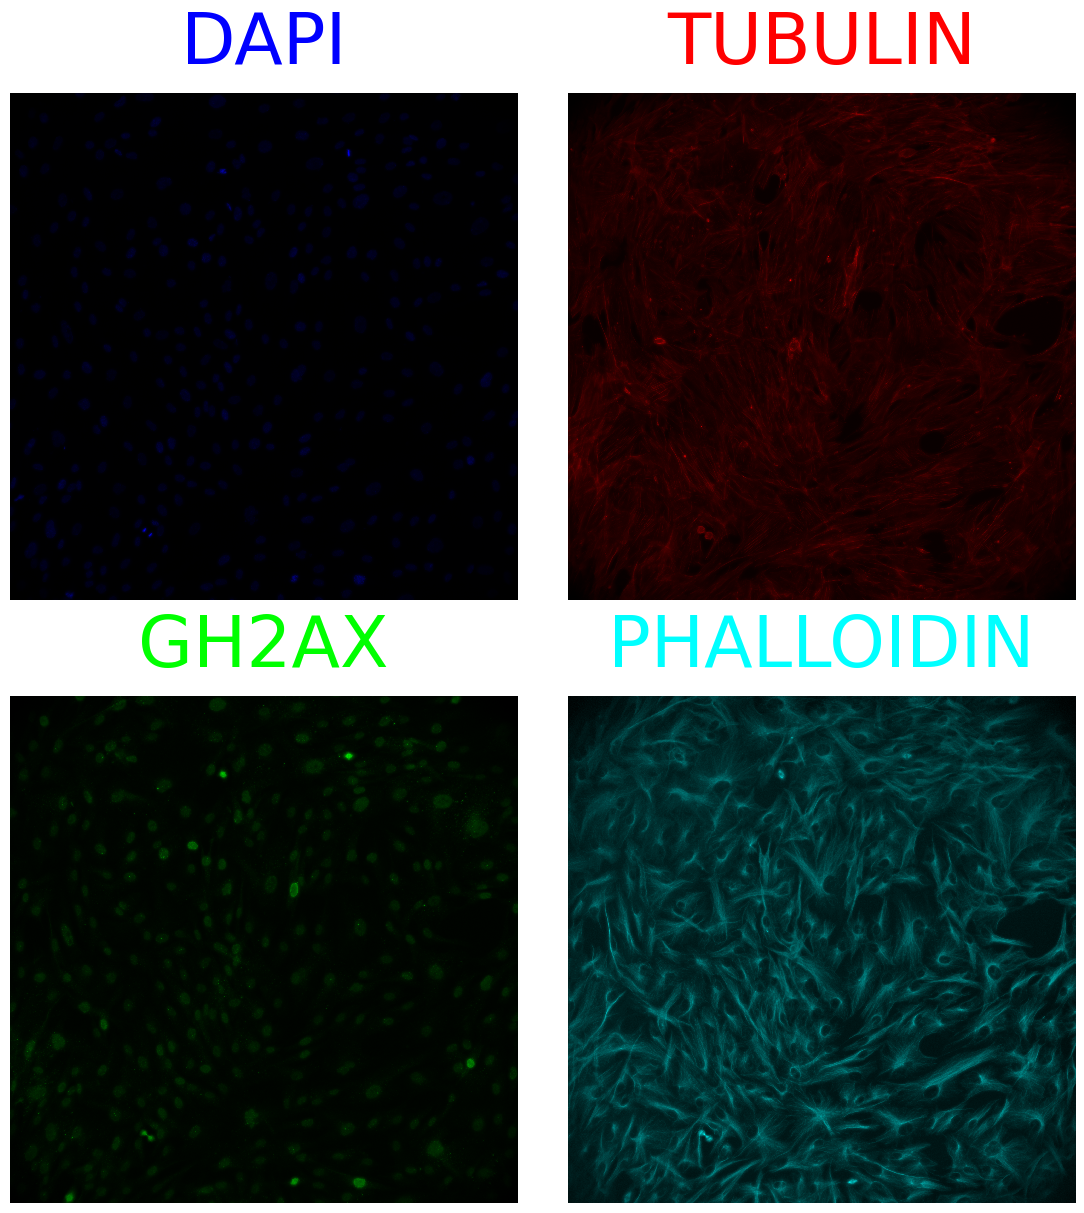

In [5]:
# load config file
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

# load test image data
print("Loading test image...")
ROOT_FP = Path(config["all"]["root_fp"])
PREPROCESS_FP = ROOT_FP / "preprocess"
phenotype_test_image_path = str(
    PREPROCESS_FP
    / "images"
    / "phenotype"
    / get_filename(
        {"plate": TEST_PLATE, "well": TEST_WELL, "tile": TEST_TILE},
        "image",
        "tiff",
    )
)
phenotype_test_image = imread(phenotype_test_image_path)

print("Applying illumination correction...")
# Read the illumination correction file
ic_field_path = str(
    PREPROCESS_FP
    / "ic_fields"
    / "phenotype"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL}, "ic_field", "tiff")
)
ic_field = imread(ic_field_path)

# This corresponds to the 'apply_illumination_correction' rule in Snakemake
corrected_image = apply_ic_field(phenotype_test_image, correction=ic_field)

# Create and display micropanel of corrected images
print("Example corrected image:")
corrected_microimages = [
    Microimage(
        corrected_image[i], channel_names=CHANNEL_NAMES[i], cmaps=CHANNEL_CMAPS[i]
    )
    for i in range(corrected_image.shape[0])
]
corrected_panel = create_micropanel(corrected_microimages, add_channel_label=True)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Automated Aligment (optional)

- `ALIGN`: Whether to conduct automated alignment. This is suggested **unless** each image is captured with each channel consecutively.
- `TARGET`: Index of the channel that other channels will be aligned to.
- `SOURCE`: Index of the channel to align with the target.
- `RIDERS`: Additional channel indices that should follow the same alignment as the source channel.
- `REMOVE_CHANNEL`: Specifies whether to remove channels after alignment. In the case of duplicate channels that are used to align the image, should be set to `source`.

In [6]:
# Set alignment parameters
ALIGN = True
TARGET = "DAPI"
SOURCE = "GH2AX"
RIDERS = ["PHALLOIDIN"]
REMOVE_CHANNEL = None

# Derive alignment indexes
if ALIGN:
    TARGET_INDEX = CHANNEL_NAMES.index(TARGET)
    SOURCE_INDEX = CHANNEL_NAMES.index(SOURCE)
    RIDER_INDEXES = [CHANNEL_NAMES.index(r) for r in RIDERS]

In [7]:
if ALIGN:
    print("Aligning channels...")
    aligned_image = align_phenotype_channels(
        corrected_image,
        target=TARGET_INDEX,
        source=SOURCE_INDEX,
        riders=RIDER_INDEXES,
        remove_channel=REMOVE_CHANNEL,
    )
    # Automatically remove channels based on REMOVE_CHANNEL
    if REMOVE_CHANNEL == "source":
        remove_index = CHANNEL_NAMES.index(SOURCE)
        CHANNEL_NAMES.pop(remove_index)
        CHANNEL_CMAPS.pop(remove_index)
    elif REMOVE_CHANNEL == "target":
        remove_index = CHANNEL_NAMES.index(TARGET)
        CHANNEL_NAMES.pop(remove_index)
        CHANNEL_CMAPS.pop(remove_index)
    elif REMOVE_CHANNEL == "riders":
        # Remove riders in reverse order to maintain correct indices
        for rider in reversed(RIDERS):
            remove_index = CHANNEL_NAMES.index(rider)
            CHANNEL_NAMES.pop(remove_index)
            CHANNEL_CMAPS.pop(remove_index)
else:
    aligned_image = corrected_image

Aligning channels...


## <font color='red'>SET PARAMETERS</font>

### Segmentation

#### Select Segmentation Method
- `SEGMENTATION_METHOD`: Choose from "cellpose", "microsam", or "stardist" for cell segmentation.

#### Common Parameters
- `CYTO_CHANNEL`: Channel to use for cell detection (typically "PHALLOIDIN")
- `HELPER_CHANNEL`: Optional channel to use for cell detection. Set to None if you only want to use CYTO_CHANNEL only.
- `GPU`: Set to True to use GPU acceleration (if available)
- `RECONCILE`: Method for reconciling nuclei and cell masks (typically "contained_in_cells", which allows more than one nucleus per cell and is useful for cells that are dividing)

#### Cellpose Parameters (if using "cellpose")
- `CELLPOSE_MODEL`: CellPose model to use (if CPSAM was re-trained). Default is "cpsam".
- `FLOW_THRESHOLD`: Flow threshold for Cellpose segmentation. Default is 0.4. Range 0.1 to 3.0.
- `CELLPROB_THRESHOLD`: Cell probability threshold for Cellpose. Default is 0. Range –6.0 to +6.0.
- `NUCLEI_DIAMETER`: Nuclei diameter in pixels. Must be set manually for CPSAM model (cannot be estimated automatically).
- `CELL_DIAMETER`: Cell diameter in pixels. Must be set manually for CPSAM model (cannot be estimated automatically).
- Note: For CPSAM model, nuclei and cell diameters must be manually specified and cannot be estimated automatically.

#### MicroSAM Parameters (if using "microsam")
- `MICROSAM_MODEL`: MicroSAM model type. Default is "vit_b_lm".
- `POINTS_PER_SIDE`: Number of points to sample along each side of the image. Default is 32.
- `POINTS_PER_BATCH`: Number of points to process in one batch. Default is 16.
- `STABILITY_SCORE_THRESH`: Threshold for stability score. Default is 0.95.
- `PRED_IOU_THRESH`: Threshold for predicted IoU. Default is 0.88.

#### StarDist Parameters (if using "stardist")
- `STARDIST_MODEL`: StarDist model type. Default is "2D_versatile_fluo".
- `PROB_THRESH`: Probability threshold for segmentation. Default is 0.479071.
- `NMS_THRESH`: Non-maximum suppression threshold. Default is 0.3.

Note: You may want to adjust these parameters and run segmentation tests if you feel you are capturing too little or too much area for the masks. For the CPSAM model, the nuclei and cell diameters must be manually specified and cannot be automatically estimated.

In [15]:
# Common parameters
CYTO_CHANNEL = "PHALLOIDIN"
HELPER_CHANNEL = "TUBULIN"
GPU = True
RECONCILE = "contained_in_cells"
DAPI_INDEX = CHANNEL_NAMES.index("DAPI")
CYTO_INDEX = CHANNEL_NAMES.index(CYTO_CHANNEL)
HELPER_INDEX = CHANNEL_NAMES.index(HELPER_CHANNEL)

# Select segmentation method
SEGMENTATION_METHOD = "cellpose"

if SEGMENTATION_METHOD == "cellpose":
    # Parameters for CellPose method
    CELLPOSE_MODEL = "cpsam"
    NUCLEI_DIAMETER = 60
    CELL_DIAMETER = 180
    NUCLEI_FLOW_THRESHOLD = 0.4
    NUCLEI_CELLPROB_THRESHOLD = 0
    CELL_FLOW_THRESHOLD = 0.4 
    CELL_CELLPROB_THRESHOLD = 1
    SEGMENT_CELLS = True 

elif SEGMENTATION_METHOD == "microsam":
    # Parameters for MicroSAM method
    MICROSAM_MODEL = "vit_b_lm"
    POINTS_PER_SIDE = 32
    POINTS_PER_BATCH = 16
    STABILITY_SCORE_THRESH = 0.95
    PRED_IOU_THRESH = 0.88

elif SEGMENTATION_METHOD == "stardist":
    # Parameters for StarDist method
    STARDIST_MODEL = "2D_versatile_fluo"
    PROB_THRESH = 0.479071
    NMS_THRESH = 0.3

Segmenting image with cellpose...


found 372 nuclei before removing edges
found 303 cells before removing edges


removing edges


found 353 nuclei before reconciling
found 267 cells before reconciling


reconciling masks with method how=contained_in_cells

Nuclei per cell statistics:
--------------------------
Cells with 0 nuclei: 5
Cells with 1 nuclei: 249
Cells with 2 nuclei: 13
--------------------------



found 262 nuclei/cells after reconciling


Number of nuclei segmented: 262
Number of cells segmented: 262
Example microplots for DAPI channel and nuclei segmentation:


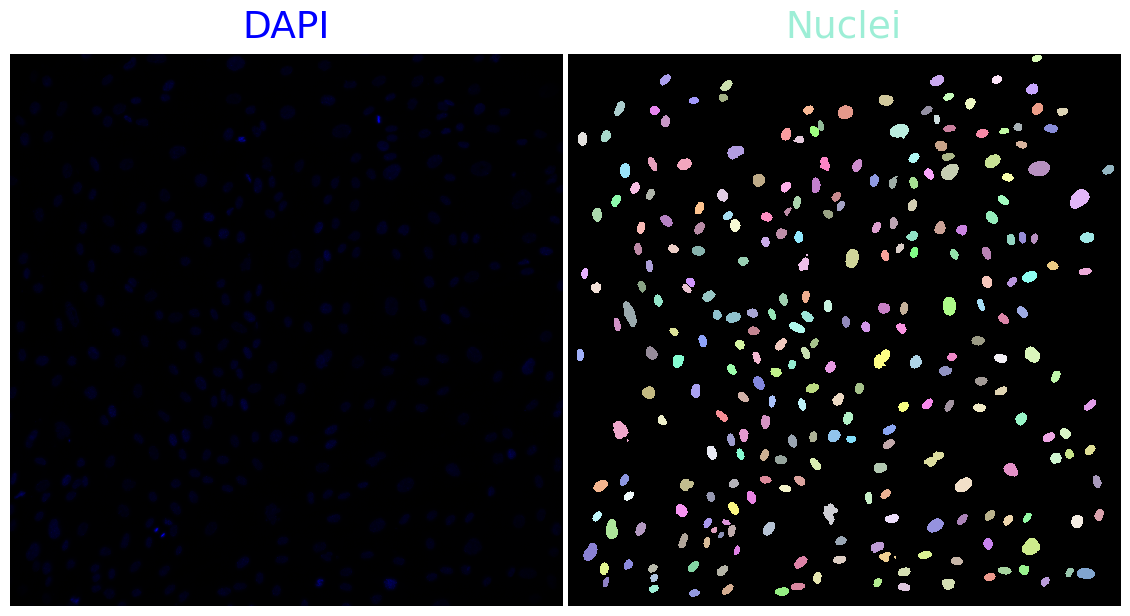

Example microplots for merged channels and cells segmentation:


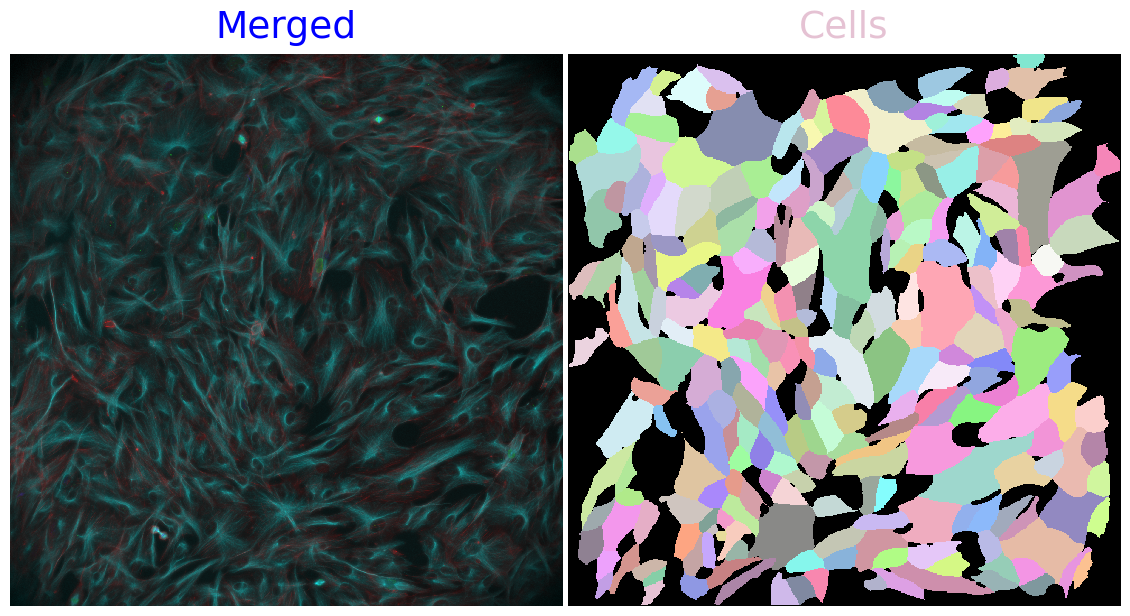

Example microplot for phenotype data annotated with segmentation:


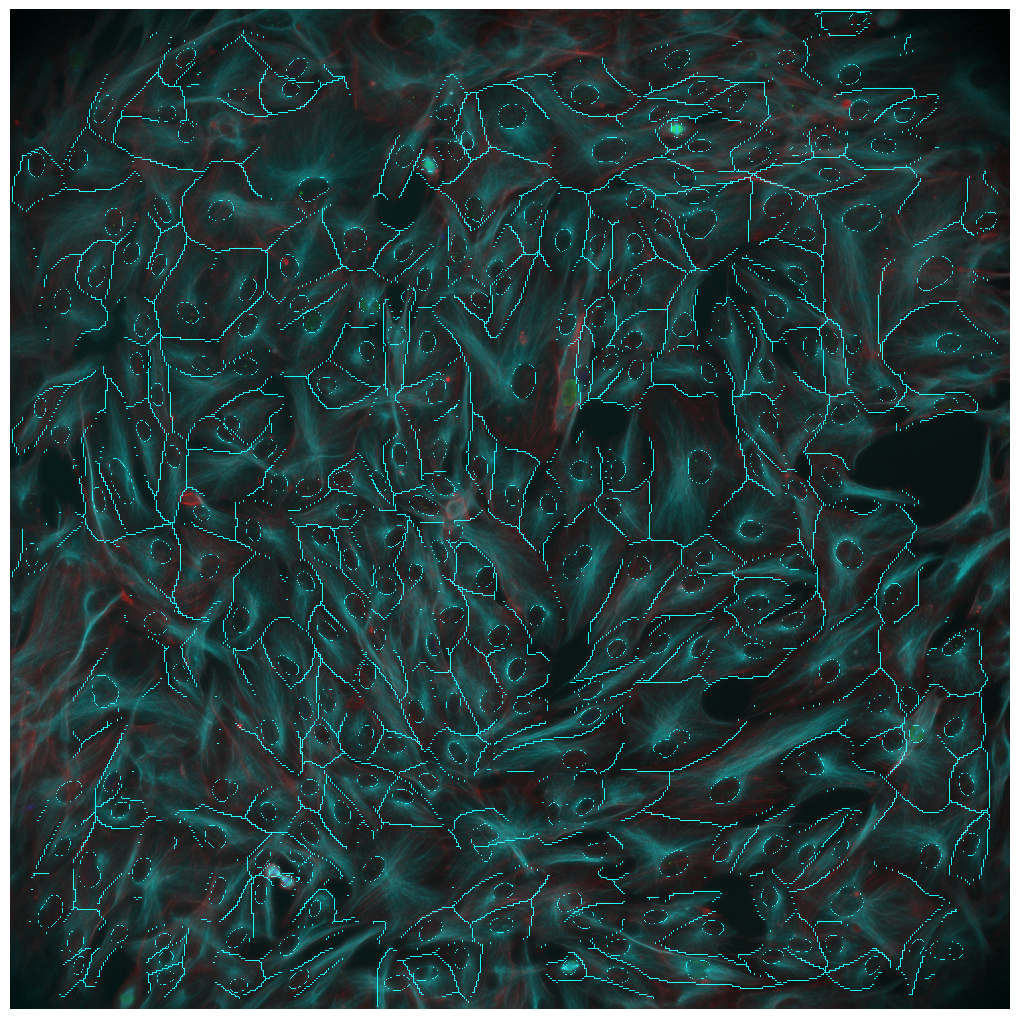

Example microplots for cytoplasms relative to nuclei:
Number of cytoplasms identified: 262


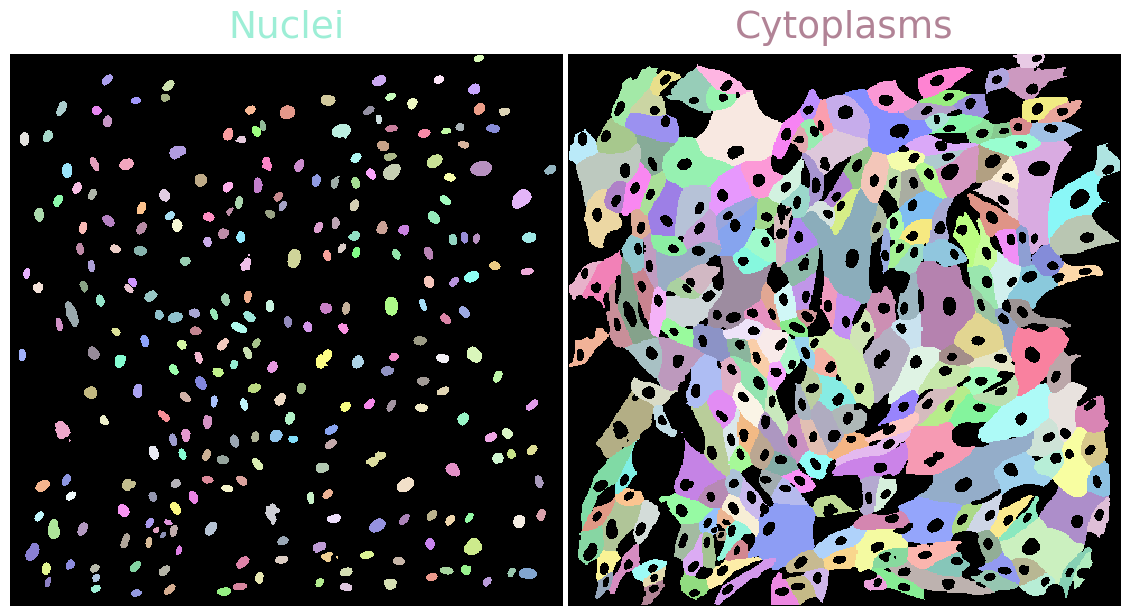

In [16]:
print(f"Segmenting image with {SEGMENTATION_METHOD}...")

if SEGMENTATION_METHOD == "cellpose":
    from lib.shared.segment_cellpose import segment_cellpose
    nuclei, cells = segment_cellpose(
        aligned_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        helper_index=HELPER_INDEX,
        nuclei_diameter=NUCLEI_DIAMETER,
        cell_diameter=CELL_DIAMETER,
        cellpose_kwargs=dict(
            nuclei_flow_threshold=NUCLEI_FLOW_THRESHOLD,
            nuclei_cellprob_threshold=NUCLEI_CELLPROB_THRESHOLD,
            cell_flow_threshold=CELL_FLOW_THRESHOLD,
            cell_cellprob_threshold=CELL_CELLPROB_THRESHOLD,
        ),
        cyto_model=CELLPOSE_MODEL,
        gpu=GPU,
        reconcile=RECONCILE,
    )

elif SEGMENTATION_METHOD == "microsam":
    from lib.shared.segment_microsam import segment_microsam
    nuclei, cells = segment_microsam(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        model_type=MICROSAM_MODEL,
        gpu=GPU,
        reconcile=RECONCILE,
    )

elif SEGMENTATION_METHOD == "stardist":
    from lib.shared.segment_stardist import segment_stardist
    nuclei, cells = segment_stardist(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        model_type=STARDIST_MODEL,
        stardist_kwargs=dict(
            nuclei_prob_threshold=NUCLEI_PROB_THRESHOLD,
            nuclei_nms_threshold=NUCLEI_NMS_THRESHOLD,
            cell_prob_threshold=CELL_PROB_THRESHOLD,
            cell_nms_threshold=CELL_NMS_THRESHOLD,
        ),
        gpu=GPU,
        reconcile=RECONCILE,
    )

# Create and display micropanel of nuclei segmentation
print("Example microplots for DAPI channel and nuclei segmentation:")
nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_seg_microimages = [
    Microimage(
        aligned_image[DAPI_INDEX],
        channel_names="DAPI",
        cmaps=CHANNEL_CMAPS[DAPI_INDEX],
    ),
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
]
nuclei_seg_panel = create_micropanel(nuclei_seg_microimages, add_channel_label=True)
plt.show()

# Create and display micropanel of segmented cells
print("Example microplots for merged channels and cells segmentation:")
cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
cells_seg_microimages = [
    Microimage(
        aligned_image,
        channel_names="Merged",
        cmaps=CHANNEL_CMAPS,
    ),
    Microimage(cells, cmaps=cells_cmap, channel_names="Cells"),
]
cells_seg_panel = create_micropanel(cells_seg_microimages, add_channel_label=True)
plt.show()

# Create and display micropanel of annotated phenotype data
print("Example microplot for phenotype data annotated with segmentation:")
annotated_data = image_segmentation_annotations(aligned_image, nuclei, cells)
annotated_microimage = [
    Microimage(
        annotated_data, channel_names="Merged", cmaps=CHANNEL_CMAPS + ["pure_cyan"]
    )
]
annotated_panel = create_micropanel(
    annotated_microimage, num_cols=1, figscaling=10, add_channel_label=False
)
plt.show()

# Create and display micropanel of cytoplasms
print("Example microplots for cytoplasms relative to nuclei:")
cytoplasms = identify_cytoplasm_cellpose(nuclei, cells)
cytoplasms_cmap = random_cmap(num_colors=len(np.unique(cytoplasms)))
cytoplasms_microimages = [
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
    Microimage(cytoplasms, cmaps=cytoplasms_cmap, channel_names="Cytoplasms"),
]
cytoplasms_panel = create_micropanel(cytoplasms_microimages, add_channel_label=True)
plt.show()

### Test feature extraction in cells

# <font color='red'>SET PARAMETERS</font>

## Feature extraction

 - `CP_METHOD`: Methodology for phenotype feature extraction.  
     - `cp_multichannel`: Use emulated code from original _Feldman et. al. 2019_ to extract CellProfiler-like features.
     - `cp_measure`: Use Pythonic version of [CellProfiler](https://github.com/afermg/cp_measure) directly from Imaging Platform. Still in development, may run slowly in Jupyter notebook for testing purposes.

### BEFORE USING CP MEASURE
 Ensure your current conda environment is set up for cp_measure when using this method. This can be done in the following manner:
 1. Clone brieflow environment:

    `conda create --name brieflow_cpmeasure_env --clone brieflow_main_env`

 2. Activate the environment:

     `conda activate brieflow_cpmeasure_env`

 3. Install the required package:

     `pip install cp-measure`

 4. Verify dependencies with `conda list` - cp_measure requires Python 3.8 or later, and the following package versions:

     - NumPy 1.24.3*
     - centrosome 1.3.0*
    
    If you have issues running cp_measure, you may need to downgrade these packages in the cloned environment.

In [17]:
CP_METHOD = "cp_multichannel"

In [18]:
print("Extracting phenotype features:")
if CP_METHOD == "cp_measure":
    from lib.phenotype.extract_phenotype_cp_measure import extract_phenotype_cp_measure
    # Extract features using cp_measure
    phenotype_cp = extract_phenotype_cp_measure(
        aligned_image,
        nuclei=nuclei,
        cells=cells,
        cytoplasms=cytoplasms,
        channel_names=CHANNEL_NAMES,
    )
else:
    from lib.phenotype.extract_phenotype_cp_multichannel import (
        extract_phenotype_cp_multichannel,
    )
    # extract phenotype CellProfiler information
    phenotype_cp = extract_phenotype_cp_multichannel(
        aligned_image,
        nuclei=nuclei,
        cells=cells,
        wildcards=WILDCARDS,
        cytoplasms=cytoplasms,
        foci_channel=FOCI_CHANNEL,
        channel_names=CHANNEL_NAMES,
    )

phenotype_cp

Extracting phenotype features:


label well  tile    nucleus_i    nucleus_j  nucleus_bounds_0  \
0        1   A1    50    27.771820  2509.193267                10   
1        2   A1    50   174.620690   848.181034               144   
2        3   A1    50   296.135456   276.609863               256   
3        4   A1    50   148.347642  1975.559250               120   
4        5   A1    50   193.221141  2485.062905               162   
..     ...  ...   ...          ...          ...               ...   
257    258   A1    50  2882.197674  1146.470930              2858   
258    259   A1    50  2829.445534  2553.423747              2804   
259    260   A1    50  2854.972131  1229.880328              2836   
260    261   A1    50  2834.481395  1657.318605              2810   
261    262   A1    50  2867.296069   459.315725              2848   

     nucleus_bounds_1  nucleus_bounds_2  nucleus_bounds_3       cell_i  ...  \
0                2482                48              2538    38.698473  ...   
1                 816               206               882   150.584507  ...   
2                 248               338               306   221.363636  ...   
3                1936               180              2014   147.829317  ...   
4                2452               224              2518   146.849028  ...   
..                ...               ...               ...          ...  ...   
257              1108              2906              1184  2886.380597  ...   
258              2530              2858              2578  2849.009915  ...   
259              1194              2876              1268  2864.877990  ...   
260              1634              2860              1682  2841.960000  ...   
261               434              2890               486  2886.143154  ...   

     cytoplasm_zernike_9_1  cytoplasm_zernike_9_3  cytoplasm_zernike_9_5  \
0                 0.038156               0.094685               0.084893   
1                 0.160897               0.049406               0.109345   
2                 0.028637               0.021312               0.068244   
3                 0.097912               0.090408               0.015720   
4                 0.006872               0.050149               0.100870   
..                     ...                    ...                    ...   
257               0.098008               0.045991               0.015019   
258               0.088496               0.131808               0.081730   
259               0.109758               0.051873               0.023326   
260               0.033126               0.048429               0.056942   
261               0.159335               0.116335               0.040987   

     cytoplasm_zernike_9_7  cytoplasm_zernike_9_9  \
0                 0.040748               0.006487   
1                 0.101029               0.033908   
2                 0.040313               0.010570   
3                 0.025018               0.021131   
4                 0.084400               0.034137   
..                     ...                    ...   
257               0.069418               0.065109   
258               0.054918               0.034130   
259               0.016289               0.027200   
260               0.052305               0.017764   
261               0.084159               0.028204   

     cytoplasm_number_neighbors_1  cytoplasm_percent_touching_1  \
0                               1                      0.116176   
1                               3                      0.373234   
2                               4                      0.382038   
3                               1                      0.143564   
4                               3                      0.195775   
..                            ...                           ...   
257                             1                      0.234375   
258                             2                      0.375604   
259                             2                      0.461894   
260    

In [19]:
# Remove channel names from feature names
def remove_channel_name(feature, channels):
    for channel in channels:
        feature = feature.replace(f"_{channel}", "")
    return feature


# Remove label, well, tile and isolate remaining feature names
filtered_features = [
    feature
    for feature in phenotype_cp.columns.tolist()
    if feature not in ["label", "well", "tile"]
]

# Apply the function to remove channel names
feature_types = [
    remove_channel_name(feature, CHANNEL_NAMES) for feature in filtered_features
]

# Get unique feature types
unique_feature_types = sorted(set(feature_types))

print("Unique feature types:")
unique_feature_types

Unique feature types:


['cell_K',
 'cell_angle_between_neighbors',
 'cell_area',
 'cell_bounds_0',
 'cell_bounds_1',
 'cell_bounds_2',
 'cell_bounds_3',
 'cell_center_mass_c',
 'cell_center_mass_r',
 'cell_centroid_c',
 'cell_centroid_r',
 'cell_compactness',
 'cell_convex_area',
 'cell_correlation',
 'cell_eccentricity',
 'cell_euler_number',
 'cell_extent',
 'cell_first_neighbor_distance',
 'cell_foci_area',
 'cell_foci_count',
 'cell_form_factor',
 'cell_frac_at_d_0',
 'cell_frac_at_d_1',
 'cell_frac_at_d_2',
 'cell_frac_at_d_3',
 'cell_haralick_5_0',
 'cell_haralick_5_1',
 'cell_haralick_5_10',
 'cell_haralick_5_11',
 'cell_haralick_5_12',
 'cell_haralick_5_2',
 'cell_haralick_5_3',
 'cell_haralick_5_4',
 'cell_haralick_5_5',
 'cell_haralick_5_6',
 'cell_haralick_5_7',
 'cell_haralick_5_8',
 'cell_haralick_5_9',
 'cell_hu_moments_0',
 'cell_hu_moments_1',
 'cell_hu_moments_2',
 'cell_hu_moments_3',
 'cell_hu_moments_4',
 'cell_hu_moments_5',
 'cell_hu_moments_6',
 'cell_i',
 'cell_int',
 'cell_int_edge',

In [20]:
# Calculate average areas
avg_cell_area = phenotype_cp['cell_area'].mean()
avg_nucleus_area = phenotype_cp['nucleus_area'].mean()

print(f"Average cell area: {avg_cell_area:.2f}")
print(f"Average nucleus area: {avg_nucleus_area:.2f}")

# Calculate diameters assuming circular areas
# Area = π * r² → r = sqrt(Area/π) → diameter = 2 * r = 2 * sqrt(Area/π)
avg_cell_diameter = 2 * np.sqrt(avg_cell_area / np.pi)
avg_nucleus_diameter = 2 * np.sqrt(avg_nucleus_area / np.pi)

print(f"Average cell diameter: {avg_cell_diameter:.2f}")
print(f"Average nucleus diameter: {avg_nucleus_diameter:.2f}")

# Optional: Calculate for each individual cell/nucleus
phenotype_cp['cell_diameter'] = 2 * np.sqrt(phenotype_cp['cell_area'] / np.pi)
phenotype_cp['nucleus_diameter'] = 2 * np.sqrt(phenotype_cp['nucleus_area'] / np.pi)

# Display summary statistics
print("\n--- Summary Statistics ---")
print(f"Cell area: mean={avg_cell_area:.2f}, std={phenotype_cp['cell_area'].std():.2f}")
print(f"Nucleus area: mean={avg_nucleus_area:.2f}, std={phenotype_cp['nucleus_area'].std():.2f}")
print(f"Cell diameter: mean={avg_cell_diameter:.2f}, std={phenotype_cp['cell_diameter'].std():.2f}")
print(f"Nucleus diameter: mean={avg_nucleus_diameter:.2f}, std={phenotype_cp['nucleus_diameter'].std():.2f}")

# Optional: Show first few rows with calculated diameters
print("\n--- First 5 rows with calculated diameters ---")
print(phenotype_cp[['cell_area', 'nucleus_area', 'cell_diameter', 'nucleus_diameter']].head())

Average cell area: 24009.48
Average nucleus area: 2739.45
Average cell diameter: 174.84
Average nucleus diameter: 59.06

--- Summary Statistics ---
Cell area: mean=24009.48, std=18082.37
Nucleus area: mean=2739.45, std=1142.53
Cell diameter: mean=174.84, std=53.37
Nucleus diameter: mean=59.06, std=10.92

--- First 5 rows with calculated diameters ---
   cell_area  nucleus_area  cell_diameter  nucleus_diameter
0     9432.0        1604.0     109.586474         45.191550
1    20448.0        2784.0     161.354275         59.537374
2    33264.0        3204.0     205.798543         63.870647
3    26892.0        3308.0     185.040422         64.898971
4    35172.0        3084.0     211.618480         62.663153


## Add phenotype process parameters to config file

The `mode` parameter in the config file determines how Snakemake will execute parameter searches for segmentation optimization. Setting the `mode` to `segment_phenotype_paramsearch` will systematically explore combinations of:

1. Size Parameters:
   - `nuclei_diameter`: Expected diameter of cell nuclei
   - `cell_diameter`: Expected diameter of cell cytoplasm
   
2. CellPose Parameters:
   - `flow_threshold`: Controls sensitivity of segmentation boundaries (default value 0.4)
     - Lower values: More aggressive segmentation, may over-segment
     - Higher values: More conservative, may miss cell boundaries
   - `cellprob_threshold`: Controls cell detection confidence (default value 0)
     - Lower values: Detects more potential cells, may include false positives
     - Higher values: More stringent detection, may miss weaker signals

The parameter search will:
1. Generate segmentations using different parameter combinations
2. Save results for each combination
3. Allow you to visually inspect results to choose optimal values
4. Help identify the best balance between over- and under-segmentation

Running these parameter searches is a time and resource intensive process and should only be done on a small subset of the tiles in the dataset.

In [21]:
# Add phenotype section
config["phenotype"] = {
    "foci_channel": FOCI_CHANNEL,
    "channel_names": CHANNEL_NAMES,
    "align": ALIGN,
    "dapi_index": DAPI_INDEX,
    "cyto_index": CYTO_INDEX,
    "segmentation_method": SEGMENTATION_METHOD,
    "segment_cells": SEGMENT_CELLS,
    "reconcile": RECONCILE,
    "gpu": GPU,
    "mode": None,
    "cp_method": CP_METHOD,
}

# Add method-specific parameters based on segmentation method
if SEGMENTATION_METHOD == "cellpose":
    config["phenotype"].update({
        "nuclei_diameter": NUCLEI_DIAMETER,
        "cell_diameter": CELL_DIAMETER,
        "nuclei_flow_threshold": NUCLEI_FLOW_THRESHOLD,
        "nuclei_cellprob_threshold": NUCLEI_CELLPROB_THRESHOLD,
        "cell_flow_threshold": CELL_FLOW_THRESHOLD,
        "cell_cellprob_threshold": CELL_CELLPROB_THRESHOLD,
        "cyto_model": CELLPOSE_MODEL,
        "helper_index": HELPER_INDEX,
    })
elif SEGMENTATION_METHOD == "microsam":
    config["phenotype"].update({
        "microsam_model": MICROSAM_MODEL,
        "points_per_side": POINTS_PER_SIDE,
        "points_per_batch": POINTS_PER_BATCH,
        "stability_score_thresh": STABILITY_SCORE_THRESH,
        "pred_iou_thresh": PRED_IOU_THRESH,
    })
elif SEGMENTATION_METHOD == "stardist":
    config["phenotype"].update({
        "stardist_model": STARDIST_MODEL,
        "prob_thresh": PROB_THRESH,
        "nms_thresh": NMS_THRESH,
    })

if ALIGN:  # then add the source index, rider indexes, and remove index
    config["phenotype"]["target"] = TARGET_INDEX
    config["phenotype"]["source"] = SOURCE_INDEX
    config["phenotype"]["riders"] = RIDER_INDEXES
    config["phenotype"]["remove_channel"] = REMOVE_CHANNEL

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)